# Potential Energy Surfaces

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../src/")

import hessian
import system
import chl_xtb


In [2]:
os.environ["QCORE_PATH"] = "~/qcore/cmake-build-release/bin/qcore"

In [3]:
modes = hessian.get_modes("../data/hessians/monomer_normal_modes.molden", 414, 140)

modes = modes.transpose(2, 0, 1)

In [4]:
symbols, xyz = system.read_xyz("../data/hessians/opt_bchla.xyz")

In [37]:
def propagate_along_mode(origin, mode, disp):
    mode *= 0.529177 # bohr to angstrom

    norm = np.sum(np.linalg.norm(mode, axis=1))
    
    res = origin + disp * mode/norm
    
    diff = np.sum(np.linalg.norm(origin - res, axis=1))
    
    assert(abs(diff - abs(disp)) < 1e-6)
    
    return res


propagate_along_mode(xyz, modes[5], 1)

def write_xyz(symbols, xyz):
    coord_list = ([f"['{s}', {c[0]}, {c[1]}, {c[2]}]" for s, c in zip(symbols, xyz)])
    
    return f"[{', '.join(coord_list)}]"


In [82]:
def run_displacement(mode, symbols, origin, disp):
    moved = propagate_along_mode(origin, mode, disp)
    qcore_str = f"\"res := xtb(model='chlorophyll' structure(xyz = {write_xyz(symbols, moved)}))\""

    res = chl_xtb.run_qcore(qcore_str)
    
    ground_energy = res["res"]["energy"]
    transition_energy = res["res"]["excitation_1_energy"]
    excited_energy = ground_energy + transition_energy
    
    return ground_energy, transition_energy, excited_energy


fig, ax = plt.subplots()
ax.spines['left'].set_position('center')

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

disps = np.linspace(-1, 1, 21)

for i in [336]:
    print(i, end=', ')
    energies = [run_displacement(modes[i], symbols, xyz, d) for d in disps]
    
    ground = [e[0] for e in energies]
    excited = [e[2] for e in energies]

    g_coeffs = np.polyfit(disps, ground, 2)
    e_coeffs = np.polyfit(disps, excited, 2)

    g_poly = np.poly1d(g_coeffs)
    e_poly = np.poly1d(e_coeffs)

    g_pred = g_poly(disps)
    e_pred = e_poly(disps)

    plt.scatter(disps, ground, color='black', marker='x')
    plt.plot(disps, g_pred, color='red')

    plt.scatter(disps, excited, color='black', marker='x')
    plt.plot(disps, e_pred, color='red')

336, 

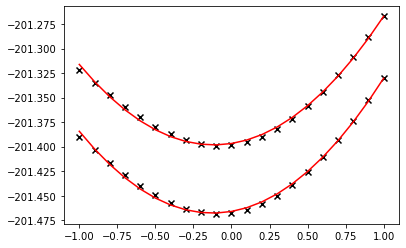

In [84]:
g_crit = g_poly.deriv().r
e_crit = e_poly.deriv().r

print(g_crit, e_crit)

[-0.12431124] [-0.11669048]
